# Use VGGish pre-trained audio feature extractor

This notebook demonstrates 
- Using VGGish in pytorch to generate audio features
- Using VGGish with OpenSoundscape
- Adding a classification layer to the feature extractor with OpenSoundscape

## quick example
this very quick example demonstrates the use of the pytorch model zoo vggish implementation:

In [183]:

import torch

model = torch.hub.load('harritaylor/torchvggish', 'vggish')
model.eval()

# Download an example audio file
import urllib
url, filename = ("http://soundbible.com/grab.php?id=1698&type=wav", "bus_chatter.wav")
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)

model.forward(filename)

Using cache found in /Users/SML161/.cache/torch/hub/harritaylor_torchvggish_master


tensor([[158.,  24., 142.,  ..., 218., 117., 255.],
        [162.,  37., 149.,  ..., 165.,   0., 255.],
        [160.,  30., 143.,  ..., 192., 191., 255.],
        ...,
        [157.,  37., 148.,  ..., 138., 189., 255.],
        [162.,  37., 155.,  ..., 156.,  14., 255.],
        [166.,  18., 156.,  ..., 172., 136., 255.]],
       grad_fn=<SqueezeBackward0>)

Let's look at the features it's creating

In [184]:
import numpy as np

In [185]:
output = model.forward(filename)

the output of the feature extractor is a vector of 128 values for each audio sample.

In this case, the model has internally preprocesses the audio file into 19 1-second Log Mel Spectrograms

In [188]:
output.shape

torch.Size([19, 128])

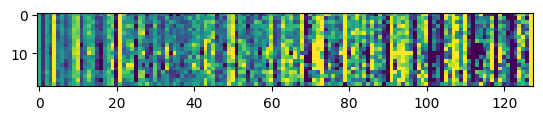

In [189]:
from matplotlib import pyplot as plt
plt.imshow(output.detach().numpy())

we can see that some features are constant across the samples while others change

# use with OpenSoundscape

In [191]:
f=filename

we'll turn of the internal preprocessing and post-processing (which applies PCA and whitening)

In [193]:
vgg = torch.hub.load('harritaylor/torchvggish', 'vggish')
vgg.preprocess = False
vgg.postprocess = False 

Using cache found in /Users/SML161/.cache/torch/hub/harritaylor_torchvggish_master


the internal preprocessor is creating MelSpectrogram samples (log valued) with shape [1,96,64]:

In [197]:
vgg._preprocess(f,fs=None).shape

torch.Size([19, 1, 96, 64])

now, let's create an OpenSoundscape CNN object using the vgg as the architecture

In [198]:
from opensoundscape.torch.models.cnn import CNN

note that we make classes a list of length 128, so that the output of the network matches the expected output size of our model

In [199]:
m = CNN(architecture=vgg,classes=np.arange(128),sample_duration=1,sample_shape=[96, 64,1])

/Users/SML161/opensoundscape/opensoundscape/torch/models/cnn.py:105: UserWarning: Make sure your architecture expects the number of channels in your input samples (1). Pytorch architectures expect 3 channels by default.
  warnings.warn(


change the preprocessing behavior to use MelSpectroram (quasi-logarithmic frequencies) instead of Spectrogram (linear frequency)

In [200]:
from opensoundscape.spectrogram import MelSpectrogram
from opensoundscape.preprocess.actions import Action
m.preprocessor.pipeline.to_spec = Action(MelSpectrogram.from_audio)

check that we preprocess samples of the correct shape

In [201]:
s,info = m.preprocessor.forward(f)
s.shape

/Users/SML161/opensoundscape/opensoundscape/audio.py:188: UserWarning: Failed to load metadata: 'artist'. Metadata will be None
  warnings.warn(f"Failed to load metadata: {e}. Metadata will be None")
/Users/SML161/opensoundscape/opensoundscape/spectrogram.py:702: FutureWarning: Pass sr=44100, n_fft=512 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  fb = librosa.filters.mel(


torch.Size([1, 96, 64])

and check that we can pass those samples to the vgg architecture and get the feature vector out

In [202]:
vgg_feat = m.network.forward(s.unsqueeze(0))
vgg_feat.shape

torch.Size([1, 128])

Now, use OpenSoundscape's mechanics to generate features on a list of files

In [203]:
preds, _, _ = m.predict([f])

/Users/SML161/opensoundscape/opensoundscape/audio.py:188: UserWarning: Failed to load metadata: 'artist'. Metadata will be None
  warnings.warn(f"Failed to load metadata: {e}. Metadata will be None")
/Users/SML161/opensoundscape/opensoundscape/spectrogram.py:702: FutureWarning: Pass sr=44100, n_fft=512 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  fb = librosa.filters.mel(
/Users/SML161/opensoundscape/opensoundscape/audio.py:188: UserWarning: Failed to load metadata: 'artist'. Metadata will be None
  warnings.warn(f"Failed to load metadata: {e}. Metadata will be None")
/Users/SML161/opensoundscape/opensoundscape/spectrogram.py:702: FutureWarning: Pass sr=44100, n_fft=512 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  fb = librosa.filters.mel(
/Users/SML161/opensoundscape/opensoundscape/audio.py:188: UserWarning: Failed to load metadata: 'artist'. Metadata will be None
  warnings.war

In [204]:
preds

0    1         2    3         4    5    \
file            start_time end_time                                           
bus_chatter.wav 0.0        1.0       0.0  0.0  0.278471  0.0  0.151628  0.0   
                1.0        2.0       0.0  0.0  0.257660  0.0  0.167520  0.0   
                2.0        3.0       0.0  0.0  0.277238  0.0  0.173320  0.0   
                3.0        4.0       0.0  0.0  0.235431  0.0  0.187473  0.0   
                4.0        5.0       0.0  0.0  0.252497  0.0  0.190735  0.0   
                5.0        6.0       0.0  0.0  0.231514  0.0  0.189389  0.0   
                6.0        7.0       0.0  0.0  0.293826  0.0  0.150943  0.0   
                7.0        8.0       0.0  0.0  0.196446  0.0  0.212592  0.0   
                8.0        9.0       0.0  0.0  0.236335  0.0  0.181137  0.0   
                9.0        10.0      0.0  0.0  0.222815  0.0  0.176373  0.0   
                10.0       11.0      0.0  0.0  0.242644  0.0  0.178091  0.0   
                11.0       12.0      0.0  0.0  0.248261  0.0  0.159815  0.0   
                12.0       13.0      0.0  0.0  0.235566  0.0  0.224073  0.0   
                13.0       14.0      0.0  0.0  0.217955  0.0  0.202602  0.0   
                14.0       15.0      0.0  0.0  0.248950  0.0  0.156188  0.0   
                15.0       16.0      0.0  0.0  0.306571  0.0  0.154496  0.0   
                16.0       17.0      0.0  0.0  0.279230  0.0  0.175175  0.0   
                17.0       18.0      0.0  0.0  0.163487  0.0  0.244820  0.0   

                                     6    7    8    9    ...  118       119  \
file            start_time end_time                      ...                  
bus_chatter.wav 0.0        1.0       0.0  0.0  0.0  0.0  ...  0.0  0.124921   
                1.0        2.0       0.0  0.0  0.0  0.0  ...  0.0  0.062247   
                2.0        3.0       0.0  0.0  0.0  0.0  ...  0.0  0.000000   
                3.0        4.0       0.0  0.0  0.0  0.0  ...  0.0  0.055323   
                4.0        5.0       0.0  0.0  0.0  0.0  ...  0.0  0.030830   
                5.0        6.0       0.0  0.0  0.0  0.0  ...  0.0  0.032201   
                6.0        7.0       0.0  0.0  0.0  0.0  ...  0.0  0.000000   
                7.0        8.0       0.0  0.0  0.0  0.0  ...  0.0  0.126165   
                8.0        9.0       0.0  0.0  0.0  0.0  ...  0.0  0.000000   
                9.0        10.0      0.0  0.0  0.0  0.0  ...  0.0  0.018496   
                10.0       11.0      0.0  0.0  0.0  0.0  ...  0.0  0.084123   
                11.0       12.0      0.0  0.0  0.0  0.0  ...  0.0  0.016548   
                12.0       13.0      0.0  0.0  0.0  0.0  ...  0.0  0.067926   
                13.0       14.0      0.0  0.0  0.0  0.0  ...  0.0  0.050149   
                14.0       15.0      0.0  0.0  0.0  0.0  ...  0.0  0.030757   
                15.0       16.0      0.0  0.0  0.0  0.0  ...  0.0  0.047088   
                16.0       17.0      0.0  0.0  0.0  0.0  ...  0.0  0.000917   
                17.0       18.0      0.0  0.0  0.0  0.0  ...  0.0  0.046318   

                                     120  121  122       123       124  125  \
file            start_time end_time                                           
bus_chatter.wav 0.0        1.0       0.0  0.0  0.0  0.079170  0.088153  0.0   
                1.0        2.0       0.0  0.0  0.0  0.038897  0.008585  0.0   
                2.0        3.0       0.0  0.0  0.0  0.088737  0.000000  0.0   
                3.0        4.0       0.0  0.0  0.0  0.084498  0.000000  0.0   
                4.0        5.0       0.0  0.0  0.0  0.094437  0.000000  0.0   
                5.0        6.0       0.0  0.0  0.0  0.089037  0.000000  0.0   
                6.0        7.0       0.0  0.0  0.0  0.031819  0.000000  0.0   
                7.0        8.0       0.0  0.0  0.0  0.124310  0.087042  0.0   
                8.0        9.0       0.0  0.0  0.0  0.080504  0.000000  0.0   
      

# add classification layer after vgg feature extractor 
we can add other layers after the VGGish feature extractor and train them on a desired number of classes. The simplest approach is to add a fully connected layer mapping 128 inputs to [the number of classes] outputs. 

In [164]:
from torch import nn

In [171]:
m = CNN(architecture=vgg,classes=np.arange(128),sample_duration=1,sample_shape=[96, 64,1])
m.preprocessor.pipeline.to_spec = Action(MelSpectrogram.from_audio)

/Users/SML161/opensoundscape/opensoundscape/torch/models/cnn.py:105: UserWarning: Make sure your architecture expects the number of channels in your input samples (1). Pytorch architectures expect 3 channels by default.
  warnings.warn(


### freeze VGGish weights
If we were to train this model, we would probably want to freeze vggish and only train the layers we are adding on. Let's freeze all parameters currently in the architecture

In [205]:
for param in m.network.parameters():
    param.requires_grad=False

### add fully connected layer

In [206]:
m.classes = ['frog','notfrog'] #set of classes we want to recognize
fc = nn.Linear(in_features=128,out_features=len(m.classes))
m.network.embeddings.add_module('fc',fc)

In [208]:
preds, _, _ = m.predict([f])

/Users/SML161/opensoundscape/opensoundscape/audio.py:188: UserWarning: Failed to load metadata: 'artist'. Metadata will be None
  warnings.warn(f"Failed to load metadata: {e}. Metadata will be None")
/Users/SML161/opensoundscape/opensoundscape/spectrogram.py:702: FutureWarning: Pass sr=44100, n_fft=512 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  fb = librosa.filters.mel(
/Users/SML161/opensoundscape/opensoundscape/audio.py:188: UserWarning: Failed to load metadata: 'artist'. Metadata will be None
  warnings.warn(f"Failed to load metadata: {e}. Metadata will be None")
/Users/SML161/opensoundscape/opensoundscape/spectrogram.py:702: FutureWarning: Pass sr=44100, n_fft=512 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  fb = librosa.filters.mel(
/Users/SML161/opensoundscape/opensoundscape/audio.py:188: UserWarning: Failed to load metadata: 'artist'. Metadata will be None
  warnings.war

frog   notfrog
file            start_time end_time                    
bus_chatter.wav 0.0        1.0       0.037825 -0.044471
                1.0        2.0       0.048731 -0.025217
                2.0        3.0       0.029733 -0.019102
                3.0        4.0       0.058458 -0.038375
                4.0        5.0       0.038907 -0.020259
                5.0        6.0       0.035583 -0.032007
                6.0        7.0       0.036369 -0.012072
                7.0        8.0       0.061777 -0.037487
                8.0        9.0       0.038710 -0.015797
                9.0        10.0      0.039489 -0.018754
                10.0       11.0      0.047219 -0.022538
                11.0       12.0      0.041551 -0.025012
                12.0       13.0      0.050307 -0.034695
                13.0       14.0      0.053348 -0.026717
                14.0       15.0      0.051504 -0.029674
                15.0       16.0      0.041777 -0.022258
                16.0       17.0      0.043781 -0.043807
                17.0       18.0      0.060804 -0.041682

In [209]:
preds

frog   notfrog
file            start_time end_time                    
bus_chatter.wav 0.0        1.0       0.037825 -0.044471
                1.0        2.0       0.048731 -0.025217
                2.0        3.0       0.029733 -0.019102
                3.0        4.0       0.058458 -0.038375
                4.0        5.0       0.038907 -0.020259
                5.0        6.0       0.035583 -0.032007
                6.0        7.0       0.036369 -0.012072
                7.0        8.0       0.061777 -0.037487
                8.0        9.0       0.038710 -0.015797
                9.0        10.0      0.039489 -0.018754
                10.0       11.0      0.047219 -0.022538
                11.0       12.0      0.041551 -0.025012
                12.0       13.0      0.050307 -0.034695
                13.0       14.0      0.053348 -0.026717
                14.0       15.0      0.051504 -0.029674
                15.0       16.0      0.041777 -0.022258
                16.0       17.0      0.043781 -0.043807
                17.0       18.0      0.060804 -0.041682